In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

,PS,QV2M,AVG_TS,T2M_RANGE,T2M_MAX,T2M_MIN
Date,,,,,,
2000-01-01,87.67,2.32,7.41,11.30,18.80,7.49
2000-01-02,87.63,2.38,8.07,11.36,20.19,8.83
2000-01-03,87.50,2.32,7.77,10.91,19.48,8.57
2000-01-04,87.48,2.32,7.77,12.27,19.65,7.38
2000-01-05,87.54,2.20,7.90,12.14,19.87,7.73


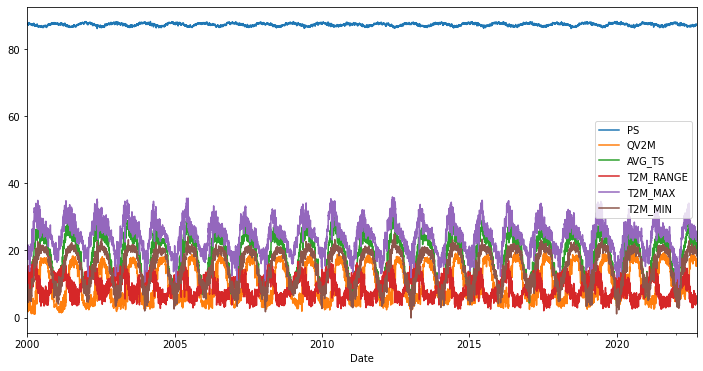

In [2]:
df = pd.read_csv('./temperature.csv',index_col='Date',parse_dates=True)
df=df.dropna()
df.plot(figsize=(12,6))
df.head()

In [3]:
df = df.iloc[:,2:3]
df.head()

,AVG_TS
Date,
2000-01-01,7.41
2000-01-02,8.07
2000-01-03,7.77
2000-01-04,7.77
2000-01-05,7.90


<AxesSubplot:xlabel='Date'>

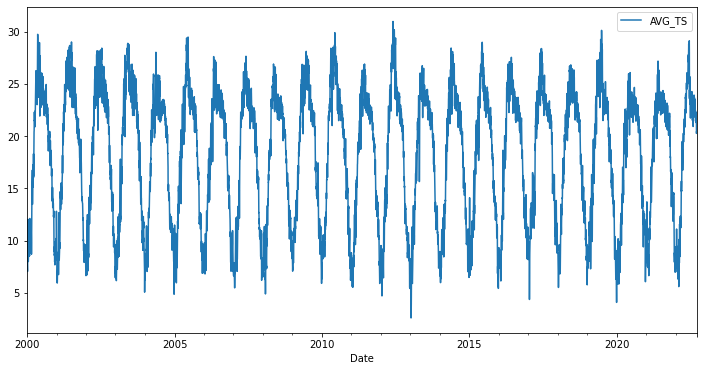

In [4]:
df.plot(figsize=(12,6))

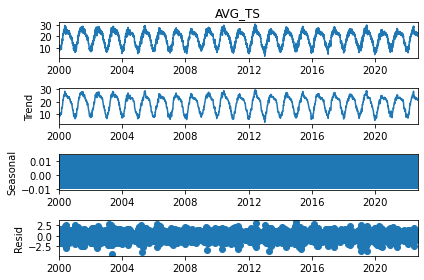

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['AVG_TS'])
results.plot();

In [6]:
len(df)

8292

In [7]:
train = df.iloc[:-365]
test = df.iloc[-365:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
df.head(),df.tail()

(            AVG_TS
 Date              
 2000-01-01    7.41
 2000-01-02    8.07
 2000-01-03    7.77
 2000-01-04    7.77
 2000-01-05    7.90,
             AVG_TS
 Date              
 2022-09-09   21.29
 2022-09-10   22.16
 2022-09-11   22.17
 2022-09-12   20.26
 2022-09-13   20.41)

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.16954529 0.19280931 0.18223476 0.18223476 0.18681706 0.17765245
 0.16038068 0.15685583 0.18329221 0.24074727 0.26260134 0.27106098]
Predict this y: 
 [[0.33309834]]


In [15]:
X.shape


(1, 12, 1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [18]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit model
model.fit(generator,epochs=10)

Epoch 1/10
7915/7915 [==============================] - 49s 6ms/step - loss: 0.0029
Epoch 2/10
7915/7915 [==============================] - 52s 7ms/step - loss: 0.0012
Epoch 3/10
7915/7915 [==============================] - 45s 6ms/step - loss: 0.0011
Epoch 4/10
7915/7915 [==============================] - 49s 6ms/step - loss: 0.0011
Epoch 5/10
7915/7915 [==============================] - 44s 6ms/step - loss: 0.0010
Epoch 6/10
7915/7915 [==============================] - 44s 6ms/step - loss: 0.0010
Epoch 7/10
7915/7915 [==============================] - 46s 6ms/step - loss: 0.0010
Epoch 8/10
7915/7915 [==============================] - 44s 6ms/step - loss: 9.8048e-04
Epoch 9/10
7915/7915 [==============================] - 49s 6ms/step - loss: 9.8614e-04
Epoch 10/10
7915/7915 [==============================] - 49s 6ms/step - loss: 9.7781e-04


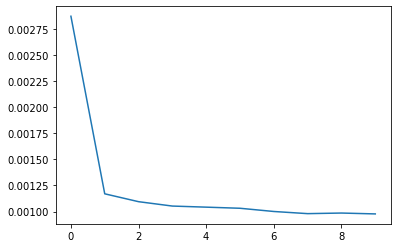

In [21]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [22]:
last_train_batch = scaled_train[-12:]

In [23]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [24]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 218ms/step


array([[0.7096796]], dtype=float32)

In [25]:
scaled_test[0]

array([0.64998238])

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 39ms/step


In [27]:

test_predictions

[array([0.7096796], dtype=float32),
 array([0.702498], dtype=float32),
 array([0.6978716], dtype=float32),
 array([0.6942155], dtype=float32),
 array([0.690732], dtype=float32),
 array([0.6875537], dtype=float32),
 array([0.6847249], dtype=float32),
 array([0.6821303], dtype=float32),
 array([0.6797882], dtype=float32),
 array([0.677553], dtype=float32),
 array([0.6755094], dtype=float32),
 array([0.67346215], dtype=float32),
 array([0.671411], dtype=float32),
 array([0.66942173], dtype=float32),
 array([0.667513], dtype=float32),
 array([0.66568327], dtype=float32),
 array([0.66392756], dtype=float32),
 array([0.66224277], dtype=float32),
 array([0.6606264], dtype=float32),
 array([0.65907574], dtype=float32),
 array([0.6575898], dtype=float32),
 array([0.6561673], dtype=float32),
 array([0.6548048], dtype=float32),
 array([0.6534989], dtype=float32),
 array([0.65224665], dtype=float32),
 array([0.6510461], dtype=float32),
 array([0.64989495], dtype=float32),
 array([0.6487912], dtype

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

In [29]:
test.head()

,AVG_TS,Predictions
Date,,
2021-09-14,21.04,22.733610
2021-09-15,20.63,22.529869
2021-09-16,20.62,22.398618
2021-09-17,21.32,22.294893
2021-09-18,22.07,22.196067


<AxesSubplot:xlabel='Date'>

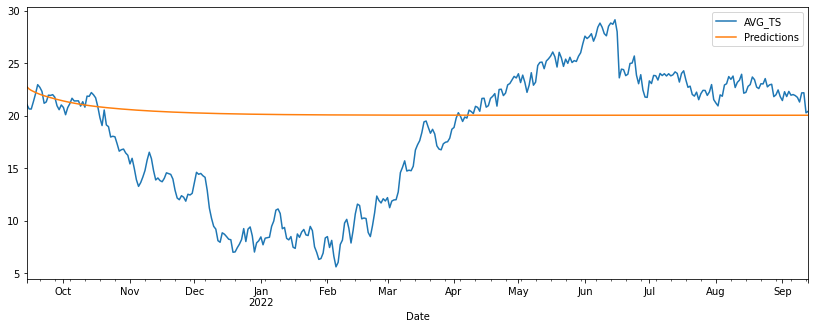

In [30]:

test.plot(figsize=(14,5))


In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['AVG_TS'],test['Predictions']))
print(rmse)

# r2 score
from sklearn.metrics import r2_score
r2score0 = r2_score(test['AVG_TS'],test['Predictions'])
print("R2 score is: ",r2score0)



6.5675639808292265
R2 score is:  -0.11150245364019362


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3952/3952 [==============================] - 24s 6ms/step - loss: 0.0049
Epoch 2/10
3952/3952 [==============================] - 22s 5ms/step - loss: 0.0024
Epoch 3/10
3952/3952 [==============================] - 25s 6ms/step - loss: 0.0022
Epoch 4/10
3952/3952 [==============================] - 25s 6ms/step - loss: 0.0022
Epoch 5/10
3952/3952 [==============================] - 28s 7ms/step - loss: 0.0021
Epoch 6/10
3952/3952 [====

,AVG_TS,Predictions
Date,,
2021-09-14,21.04,23.149644
2021-09-16,20.62,23.318380
2021-09-18,22.07,23.561032
2021-09-20,22.69,23.816284
2021-09-22,21.17,24.060418


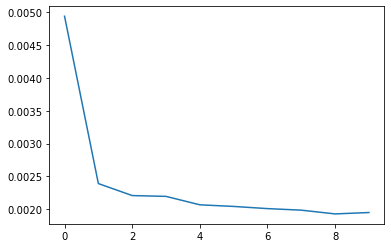

In [34]:
#1 days gap

df1 = df.iloc[:-365:2]
train1 = df1
train1.head()
scaler.fit(train1)

test1 = df.iloc[-365:]
test1 = test1.iloc[:-1:2]



scaled_train1 = scaler.transform(train1)
scaled_test1 = scaler.transform(test1)


# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train1, scaled_train1, length=n_input, batch_size=1)

X,y = generator[0]

model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')
model1.summary()

# fit model
model1.fit(generator,epochs=10)
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

last_train_batch1 = scaled_train1[-12:]
last_train_batch1 = last_train_batch1.reshape((1, n_input, n_features))
model1.predict(last_train_batch1)

test_predictions1 = []

first_eval_batch = scaled_train1[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test1)):
    
    # get the prediction value for the first batch
    current_pred = model1.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions1.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions1 = scaler.inverse_transform(test_predictions1)
test1['Predictions'] = true_predictions1
test1.head()


RMSE error for 1 day gap: 11.082807289021627
R2 score is:  -2.1727034531141904


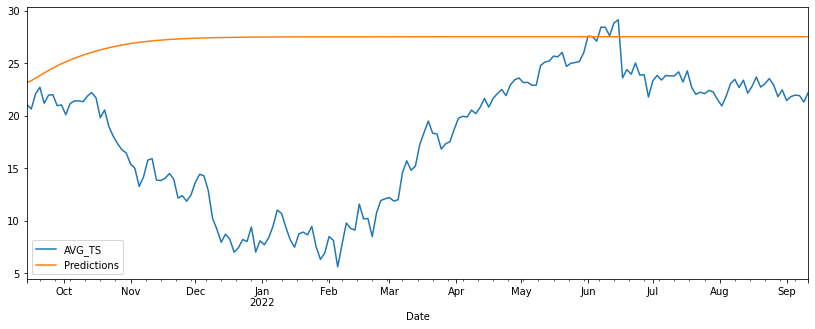

In [35]:
test1.head()
test1.plot(figsize=(14,5))

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse1=sqrt(mean_squared_error(test1['AVG_TS'],test1['Predictions']))
print("RMSE error for 1 day gap:",rmse1)

# r2 score
from sklearn.metrics import r2_score
r2score1 = r2_score(test1['AVG_TS'],test1['Predictions'])
print("R2 score is: ",r2score1)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1310/1310 [==============================] - 9s 6ms/step - loss: 0.0099
Epoch 2/10
1310/1310 [==============================] - 8s 6ms/step - loss: 0.0042
Epoch 3/10
1310/1310 [==============================] - 9s 7ms/step - loss: 0.0040
Epoch 4/10
1310/1310 [==============================] - 7s 6ms/step - loss: 0.0039
Epoch 5/10
1310/1310 [==============================] - 7s 6ms/step - loss: 0.0037
Epoch 6/10
1310/1310 [=========

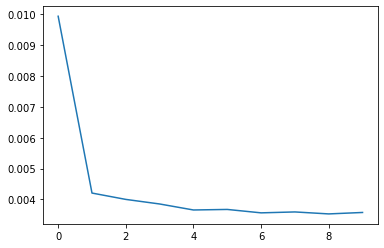

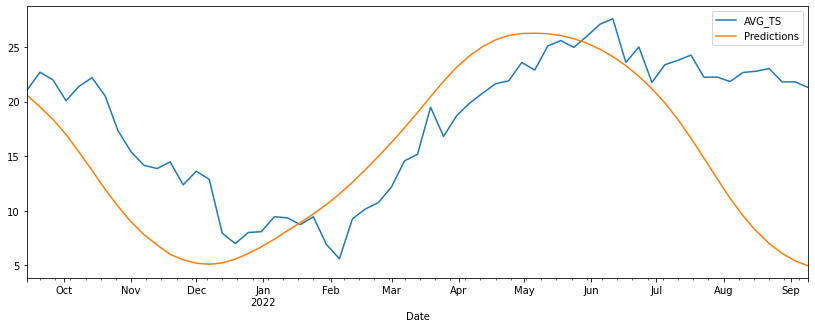

In [37]:
#5 days gap


df5 = df.iloc[:-365:6]
train5 = df5
train5.head()
scaler.fit(train5)


test5 = df.iloc[-365:]
test5 = test5.iloc[:-1:6]



scaled_train5 = scaler.transform(train5)
scaled_test5 = scaler.transform(test5)

# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train5, scaled_train5, length=n_input, batch_size=1)

X,y = generator[0]

model5 = Sequential()
model5.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model5.add(Dense(1))
model5.compile(optimizer='adam', loss='mse')
model5.summary()

# fit model
model5.fit(generator,epochs=10)
loss_per_epoch = model5.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

last_train_batch5 = scaled_train5[-12:]
last_train_batch5 = last_train_batch5.reshape((1, n_input, n_features))
model5.predict(last_train_batch5)

test_predictions5 = []

first_eval_batch = scaled_train5[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test5)):
    
    # get the prediction value for the first batch
    current_pred = model5.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions5.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions5 = scaler.inverse_transform(test_predictions5)
test5['Predictions'] = true_predictions5
test5.head()

test5.head()
test5.plot(figsize=(14,5))

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse5=sqrt(mean_squared_error(test5['AVG_TS'],test5['Predictions']))
print("RMSE error for 5 day gap in lstm",rmse5)

# r2 score
from sklearn.metrics import r2_score
r2score5 = r2_score(test5['AVG_TS'],test5['Predictions'])
print("R2 score is: ",r2score5)



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
517/517 [==============================] - 4s 6ms/step - loss: 0.0370
Epoch 2/10
517/517 [==============================] - 3s 6ms/step - loss: 0.0076
Epoch 3/10
517/517 [==============================] - 3s 6ms/step - loss: 0.0059
Epoch 4/10
517/517 [==============================] - 3s 5ms/step - loss: 0.0054
Epoch 5/10
517/517 [==============================] - 3s 5ms/step - loss: 0.0049
Epoch 6/10
517/517 [=====================

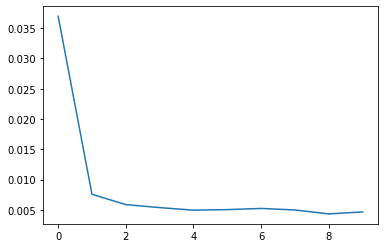

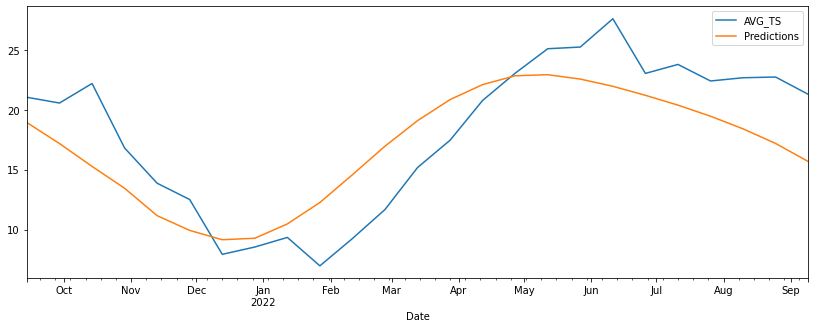

In [38]:
#14 days gap

df14 = df.iloc[:-365:15]
train14 = df14
train14.head()
scaler.fit(train14)


test14 = df.iloc[-365:]
test14 = test14.iloc[:-1:15]



scaled_train14 = scaler.transform(train14)
scaled_test14 = scaler.transform(test14)

# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train14, scaled_train14, length=n_input, batch_size=1)

X,y = generator[0]

model14 = Sequential()
model14.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model14.add(Dense(1))
model14.compile(optimizer='adam', loss='mse')
model14.summary()

# fit model
model14.fit(generator,epochs=10)
loss_per_epoch = model14.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

last_train_batch14 = scaled_train14[-12:]
last_train_batch14 = last_train_batch14.reshape((1, n_input, n_features))
model14.predict(last_train_batch14)

test_predictions14 = []

first_eval_batch = scaled_train14[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test14)):
    
    # get the prediction value for the first batch
    current_pred = model14.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions14.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions14 = scaler.inverse_transform(test_predictions14)
test14['Predictions'] = true_predictions14
test14.head()

test14.plot(figsize=(14,5))

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse14=sqrt(mean_squared_error(test14['AVG_TS'],test14['Predictions']))
print("RMSE error for 14 day gap in lstm",rmse14)

# r2 score
from sklearn.metrics import r2_score
r2score14 = r2_score(test14['AVG_TS'],test14['Predictions'])
print("R2 score is: ",r2score14)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
244/244 [==============================] - 3s 6ms/step - loss: 0.0723
Epoch 2/10
244/244 [==============================] - 1s 5ms/step - loss: 0.0208
Epoch 3/10
244/244 [==============================] - 1s 6ms/step - loss: 0.0108
Epoch 4/10
244/244 [==============================] - 2s 6ms/step - loss: 0.0076
Epoch 5/10
244/244 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 6/10
244/244 [=====================

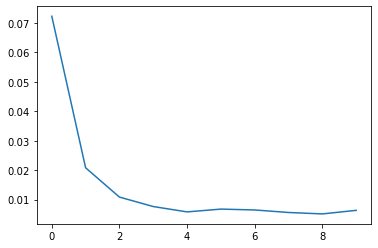

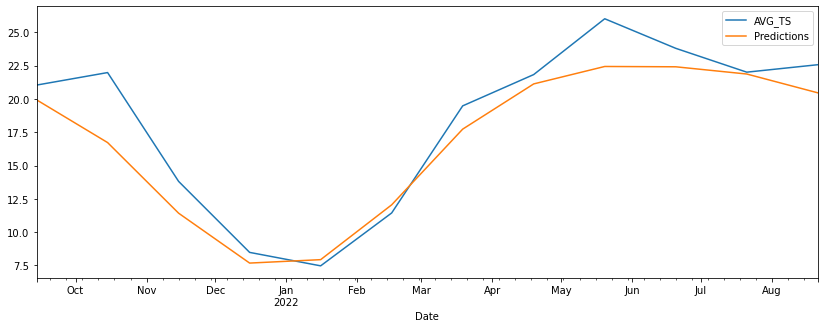

In [39]:
#30 days gap



df30 = df.iloc[:-365:31]
train30 = df30
train30.head()
scaler.fit(train30)


test30 = df.iloc[-365:]
test30 = test30.iloc[:-1:31]



scaled_train30 = scaler.transform(train30)
scaled_test30 = scaler.transform(test30)

# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train30, scaled_train30, length=n_input, batch_size=1)

X,y = generator[0]

model30 = Sequential()
model30.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model30.add(Dense(1))
model30.compile(optimizer='adam', loss='mse')
model30.summary()

# fit model
model30.fit(generator,epochs=10)
loss_per_epoch = model30.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

last_train_batch30 = scaled_train30[-12:]
last_train_batch30 = last_train_batch30.reshape((1, n_input, n_features))
model30.predict(last_train_batch30)

test_predictions30 = []

first_eval_batch = scaled_train30[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test30)):
    
    # get the prediction value for the first batch
    current_pred = model30.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions30 = scaler.inverse_transform(test_predictions30)
test30['Predictions'] = true_predictions30
test30.head()

test30.plot(figsize=(14,5))

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse30=sqrt(mean_squared_error(test30['AVG_TS'],test30['Predictions']))
print("RMSE error for 30 day gap in lstm",rmse30)

# r2 score
from sklearn.metrics import r2_score
r2score30 = r2_score(test30['AVG_TS'],test30['Predictions'])
print("R2 score is: ",r2score30)


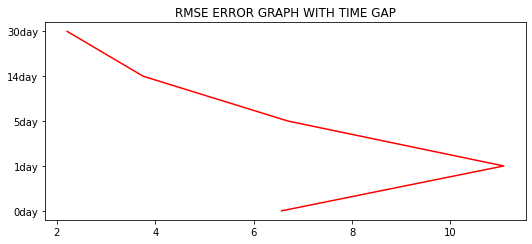

In [41]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = [rmse,rmse1,rmse5,rmse14,rmse30]
y = ["0day","1day","5day","14day","30day"]

plt.title("RMSE ERROR GRAPH WITH TIME GAP")
plt.plot(x, y, color="red")

plt.show()